In [6]:
import os
import glob
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_erosion, binary_opening, disk, ball
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes, center_of_mass, distance_transform_edt
from skimage.filters import threshold_otsu, median, gaussian
from skimage.exposure import rescale_intensity, equalize_adapthist

# --- Variáveis Globais ---

# Caminho para o diretório de dados
DATA_DIR = '../database/axl/'

# Número de imagens aleatórias para o batch
N_IMAGES_BATCH = 15

# Número de clusters (LCR, MC, MB, Fundo)
N_CLUSTERS = 4

# Limites de área 
MIN_AREA_VENTRICLE = 200 # Área mínima para um ventrículo
MIN_AREA_BRAIN = 5000     # Área mínima para o cérebro 

# Lista para armazenar os caminhos dos arquivos selecionados para o batch
SELECTED_FILES = []

# Lista para armazenar os slices 2D originais
ORIGINAL_SLICES = []

# Seed para reprodutibilidade
random.seed(64)

print("Célula 1 executada: Bibliotecas importadas e variáveis globais definidas.")

Célula 1 executada: Bibliotecas importadas e variáveis globais definidas.


Carregando 15 imagens aleatórias de ../database/axl/...
15 slices carregados na memória.


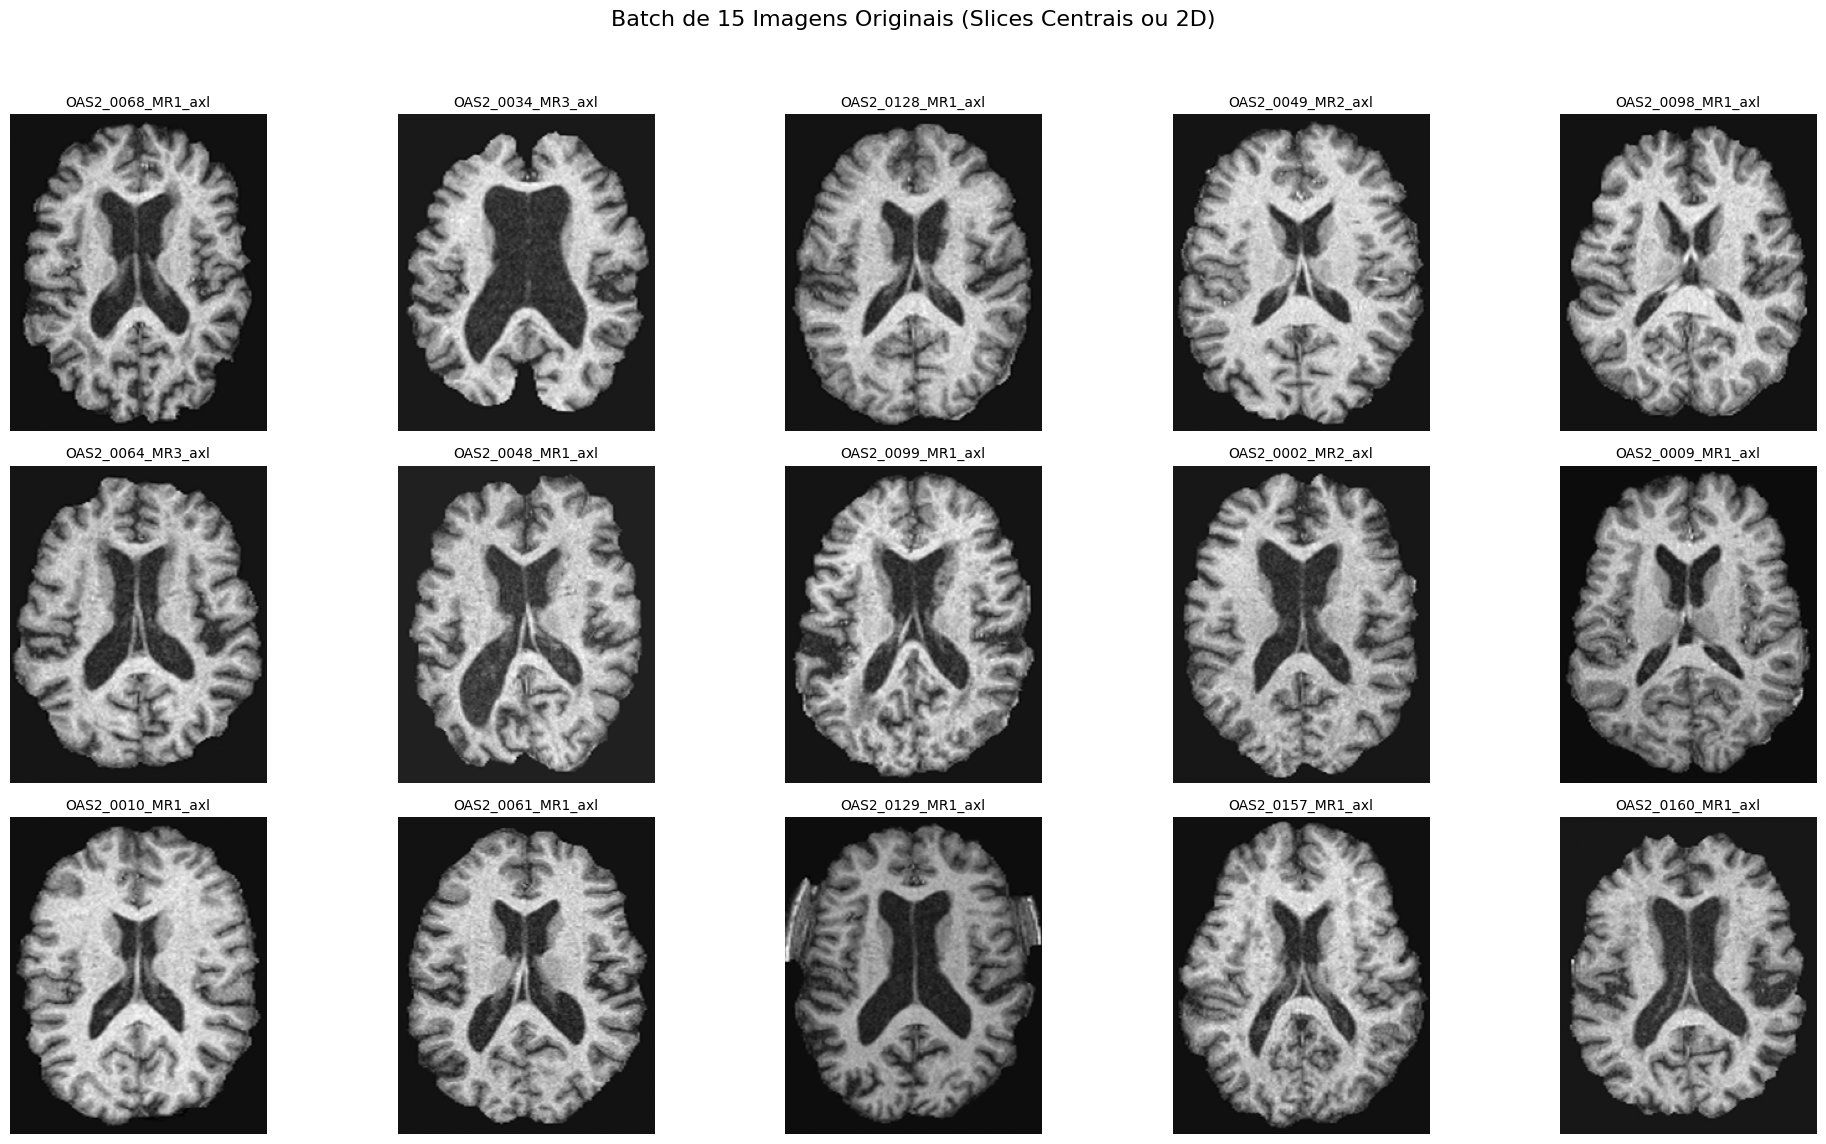

In [7]:
print(f"Carregando {N_IMAGES_BATCH} imagens aleatórias de {DATA_DIR}...")

# Limpa listas para re-execução
SELECTED_FILES = []
ORIGINAL_SLICES = []

# Busca todos os arquivos NIfTI no diretório
all_files = glob.glob(os.path.join(DATA_DIR, "*.nii.gz"))

if not all_files:
    print(f"Nenhum arquivo .nii.gz encontrado em {DATA_DIR}")
else:
    # Seleciona um batch aleatório de arquivos
    N_IMAGES_BATCH = min(N_IMAGES_BATCH, len(all_files))
    SELECTED_FILES_PATHS = random.sample(all_files, N_IMAGES_BATCH)
    
    # Carrega os slices
    for file_path in SELECTED_FILES_PATHS:
        nii_img = nib.load(file_path)
        data = nii_img.get_fdata()
        
        # Verifica a dimensionalidade dos dados
        if data.ndim == 3:
            # É um volume 3D, pega o slice central
            slice_z = data.shape[2] // 2
            slice_data = data[:, :, slice_z]
            ORIGINAL_SLICES.append(slice_data)
            SELECTED_FILES.append(file_path)
        
        elif data.ndim == 2:
            # Já é um slice 2D, apenas adiciona
            slice_data = data
            ORIGINAL_SLICES.append(slice_data)
            SELECTED_FILES.append(file_path)
            
        else:
            # Dados inesperados (1D, 4D, etc.)
            print(f"AVISO: Arquivo {os.path.basename(file_path)} ignorado. Dimensionalidade inesperada: {data.ndim}D")

    print(f"{len(ORIGINAL_SLICES)} slices carregados na memória.")

    plt.figure(figsize=(20, 12))
    for i, image_slice in enumerate(ORIGINAL_SLICES):
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.rot90(image_slice), cmap='gray')
        filename = os.path.basename(SELECTED_FILES[i]).split('.')[0]
        plt.title(filename, fontsize=10)
        plt.axis('off')
    plt.suptitle(f"Batch de {len(SELECTED_FILES)} Imagens Originais (Slices Centrais ou 2D)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [8]:
def segmentar_ventriculos(image_slice, n_clusters, min_area_brain, min_area_ventricle):
    """
    Segmenta os ventrículos cerebrais usando a lógica robusta 
    (CLAHE, Skull Stripping, K-Means + Distance Transform).
    """
    shape = image_slice.shape
    
    # 1. Pré-processamento 
    # Normaliza a imagem para 0-1
    img_norm = rescale_intensity(image_slice, out_range=(0, 1))
    
    # Aplica CLAHE (Adaptive Histogram Equalization) para melhorar o contraste
    img_clahe = equalize_adapthist(img_norm)
    
    # Suavização Gaussiana
    img_smooth = gaussian(img_clahe, sigma=1)

    # 2. Remoção do Crânio (Skull Stripping) 
    t = threshold_otsu(img_smooth)
    mask_cerebro = img_smooth > t
    
    # Limpeza morfológica da máscara
    mask_cerebro = binary_opening(mask_cerebro, disk(3))
    mask_cerebro = remove_small_objects(mask_cerebro, min_size=min_area_brain)
    mask_cerebro = binary_fill_holes(mask_cerebro)
    
    # Encontra o maior componente (cérebro)
    labels_cerebro = label(mask_cerebro)
    if labels_cerebro.max() == 0: # Imagem vazia
        return {'ventriculos': np.zeros(shape, dtype=bool)}
        
    maior_comp_label = np.argmax([region.area for region in regionprops(labels_cerebro)]) + 1
    mask_cerebro = (labels_cerebro == maior_comp_label)
    
    # Aplica a máscara
    img_sem_cranio = img_smooth * mask_cerebro

    # 3. K-Means 
    # Prepara os dados: apenas pixels do cérebro (ignora fundo)
    pixels_cerebro = img_sem_cranio[mask_cerebro].reshape(-1, 1)
    
    if pixels_cerebro.shape[0] < n_clusters:
        return {'ventriculos': np.zeros(shape, dtype=bool)}

    kmeans = KMeans(n_clusters=n_clusters, random_state=64, n_init=10).fit(pixels_cerebro)
    centers = kmeans.cluster_centers_.flatten()
    labels_flat = kmeans.labels_

    # 4. Identificação do LCR
    # O LCR (incluindo ventrículos) é o cluster de menor intensidade (sem contar o fundo)
    sorted_indices = np.argsort(centers)
    indice_lcr = sorted_indices[0] 

    # Mapeia labels de volta para a imagem
    labels_kmeans = np.zeros(shape, dtype=int)
    labels_kmeans[mask_cerebro] = labels_flat + 1 # +1 para o fundo ser 0
    
    mask_lcr_total = (labels_kmeans == (indice_lcr + 1))

    # 5. Isolamento dos Ventrículos (Lógica Robusta com Distance Transform)
    # A maior parte do LCR fora dos ventrículos está nas bordas (sulcos)
    # Os ventrículos são grandes "bolsões" internos
    
    # Calcula a transformada de distância
    dist_transform = distance_transform_edt(mask_lcr_total)
    
    # Encontra os componentes da máscara LCR
    labels_lcr = label(mask_lcr_total)
    regioes_lcr = regionprops(labels_lcr)
    
    mask_ventriculos_final = np.zeros(shape, dtype=bool)
    
    if not regioes_lcr:
        return {'ventriculos': np.zeros(shape, dtype=bool)}

    # Encontra os dois maiores componentes do LCR (geralmente os ventrículos laterais)
    # Ordena por área
    regioes_lcr.sort(key=lambda r: r.area, reverse=True)
    
    # Pega os 2 maiores componentes, desde que sejam maiores que a área mínima
    for r in regioes_lcr[:2]:
        if r.area > min_area_ventricle:
            # Adiciona o componente à máscara final
            mask_ventriculos_final[labels_lcr == r.label] = True

    # Pós-processamento final
    mask_ventriculos_final = binary_fill_holes(mask_ventriculos_final)
    
    return {
        'ventriculos': mask_ventriculos_final
        # Esta lógica não retorna mais 'materia_branca' ou 'materia_cinzenta'
    }

print("Célula 3 executada: Função 'segmentar_ventriculos'  definida.")

Célula 3 executada: Função 'segmentar_ventriculos'  definida.


Célula 4: Executando pipeline robusto de ventrículos e plotando resultados...


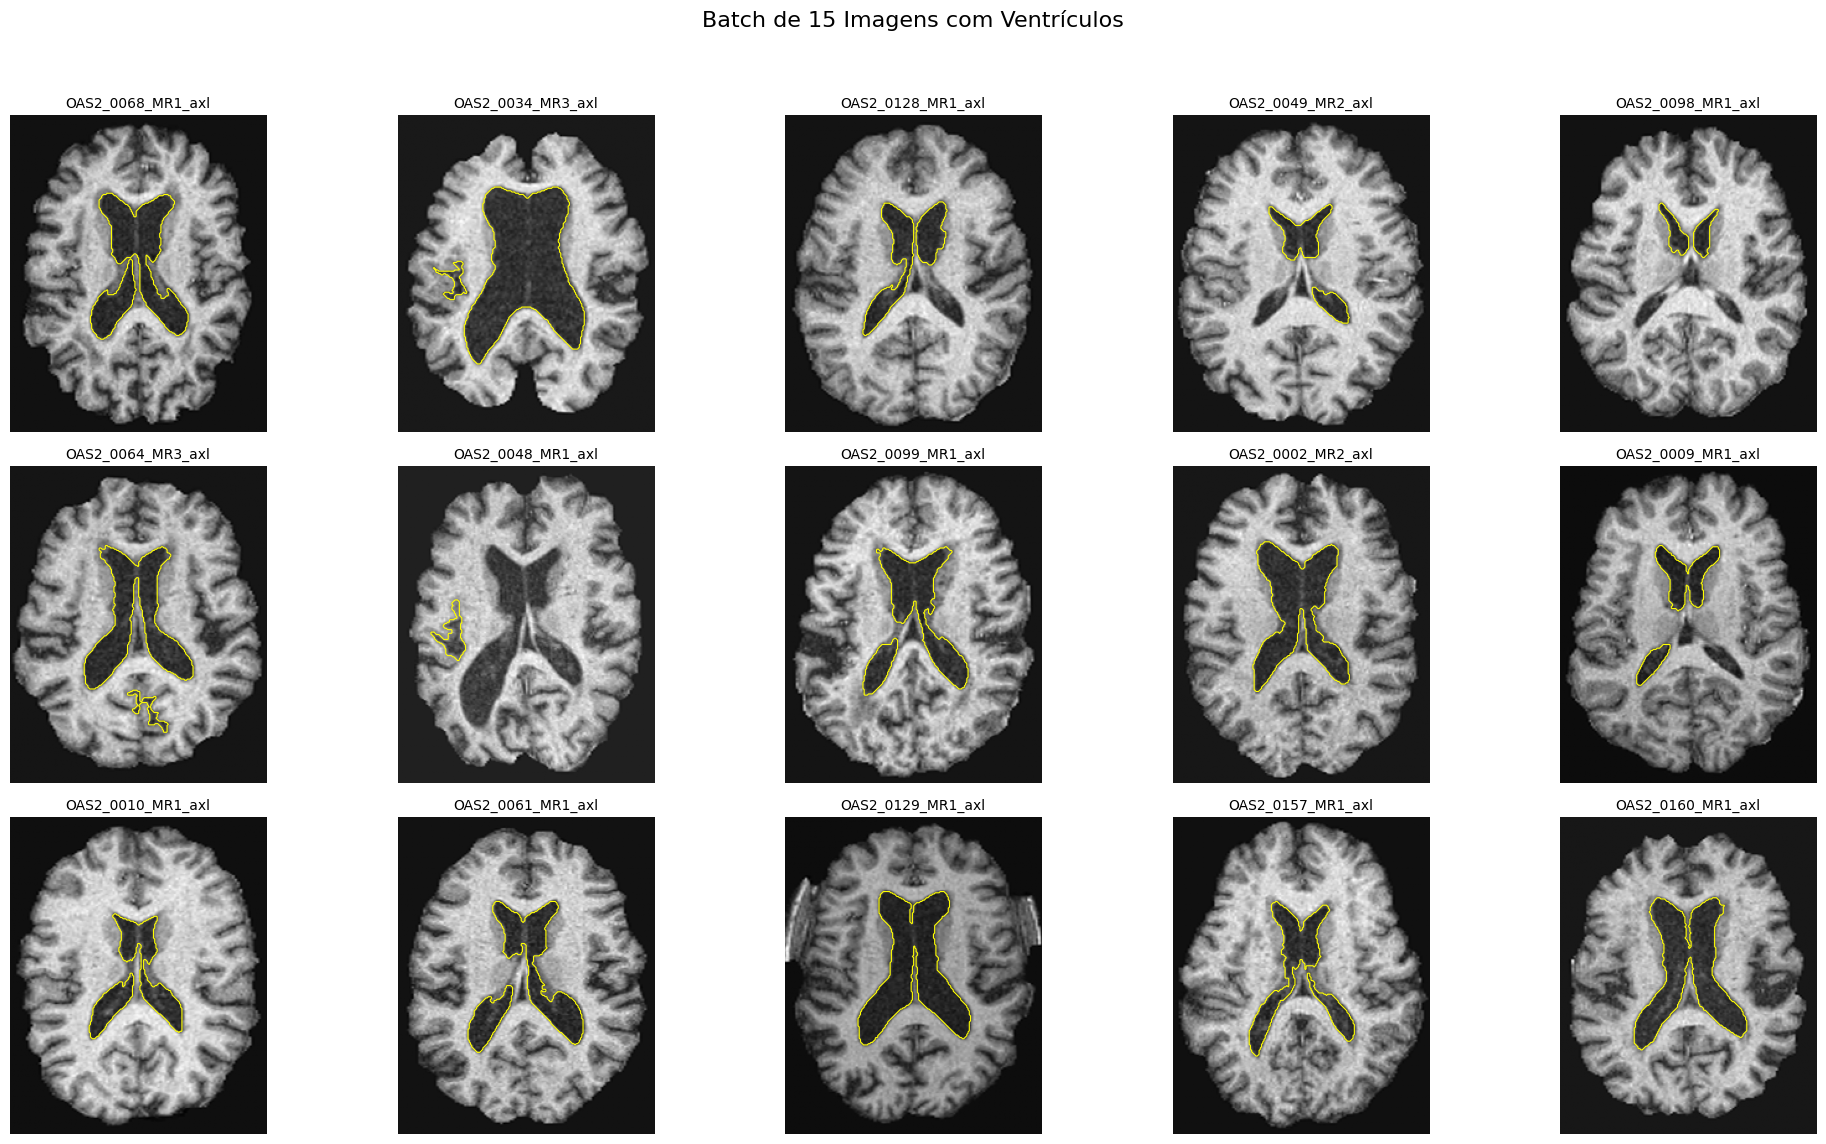

In [9]:
print("Célula 4: Executando pipeline de ventrículos e plotando resultados...")

if not ORIGINAL_SLICES:
    print("Nenhuma imagem carregada. Execute a Célula 2 primeiro.\n")
else:
    plt.figure(figsize=(20, 12))
    
    for i, image_slice in enumerate(ORIGINAL_SLICES):
        
        # 1. Gerar as máscaras
        masks = segmentar_ventriculos(image_slice, 
                                        N_CLUSTERS, 
                                        MIN_AREA_BRAIN, 
                                        MIN_AREA_VENTRICLE)
        
        # 2. Plotar a imagem original
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.rot90(ORIGINAL_SLICES[i]), cmap='gray')
        
        # 3. Sobrepor os contornos (Apenas ventrículos)
        if np.any(masks['ventriculos']):
            # Ventrículos em Amarelo 
            plt.contour(np.rot90(masks['ventriculos']), colors='yellow', linewidths=0.8)
            
        # 4. Título e eixos
        filename = os.path.basename(SELECTED_FILES[i]).split('.')[0]
        plt.title(filename, fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Batch de {len(SELECTED_FILES)} Imagens com Ventrículos", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()